# Stock Price Prediction - Time Series Analysis

In [39]:
#import the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rcParams
%matplotlib inline
from scipy.stats import norm, skew
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

In [3]:
#loadData
df_main = pd.read_csv("netflixdata.csv")
df = df_main
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


## EDA and Preprocessing

In [4]:
df.shape

(1009, 7)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1009 non-null   object 
 1   Open       1009 non-null   float64
 2   High       1009 non-null   float64
 3   Low        1009 non-null   float64
 4   Close      1009 non-null   float64
 5   Adj Close  1009 non-null   float64
 6   Volume     1009 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 55.3+ KB


In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,1.009000e+03
mean,419.059673,425.320703,412.374044,419.000733,419.000733,7.570685e+06
std,108.537532,109.262960,107.555867,108.289999,108.289999,5.465535e+06
min,233.919998,250.649994,231.229996,233.880005,233.880005,1.144000e+06
25%,331.489990,336.299988,326.000000,331.619995,331.619995,4.091900e+06
50%,377.769989,383.010010,370.880005,378.670013,378.670013,5.934500e+06
75%,509.130005,515.630005,502.529999,509.079987,509.079987,9.322400e+06
max,692.349976,700.989990,686.090027,691.690002,691.690002,5.890430e+07


In [7]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [12]:
df['Date'] = pd.to_datetime(df['Date'])

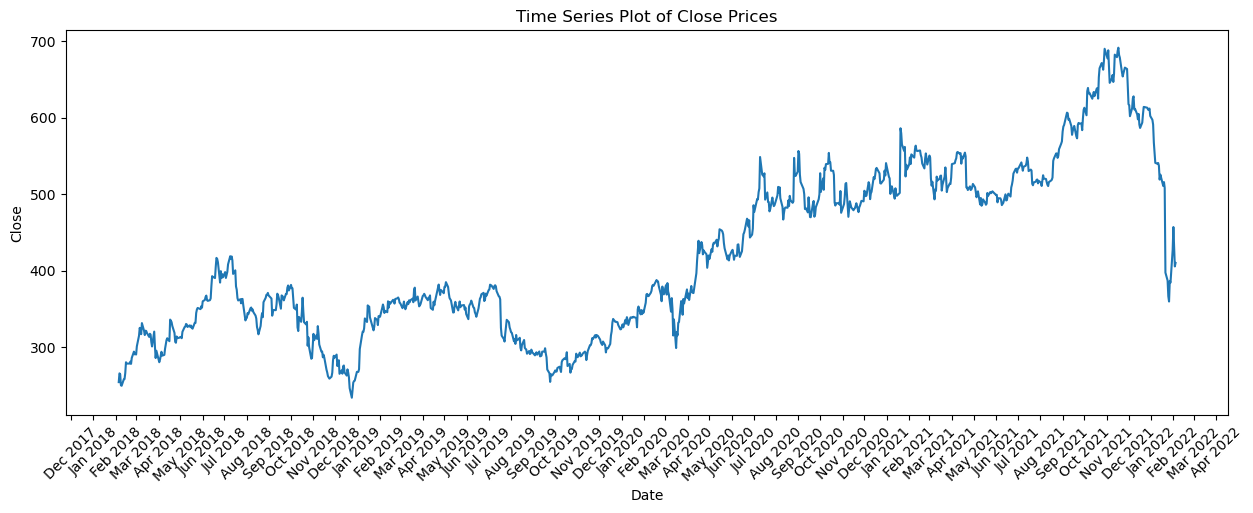

In [13]:
plt.figure(figsize=(15, 5))
plt.plot(df['Date'], df['Close'])
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Time Series Plot of Close Prices')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.show()

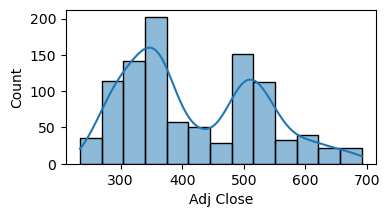

<Figure size 400x200 with 0 Axes>

In [17]:
rcParams['figure.figsize'] = 4,2
sb.histplot(df["Adj Close"], kde=True)
fig = plt.figure()


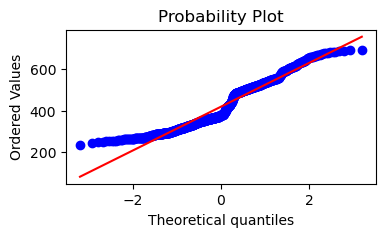

In [18]:
stats.probplot(df['Adj Close'], plot=plt)
plt.show()

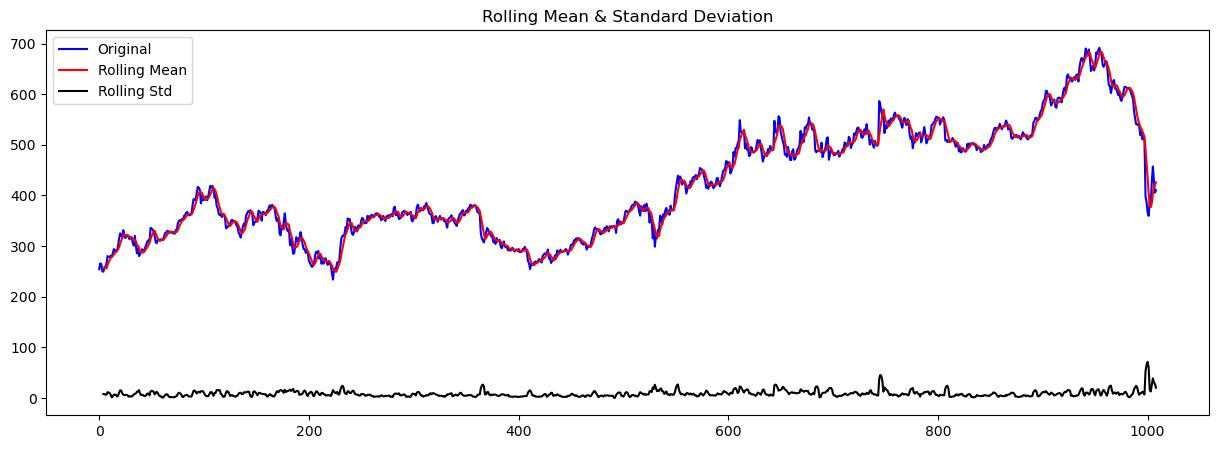

ADF Test Statistic: -1.8125906878289961
p-value: 0.37422892568207555
Lags: 6
Observation: 1002
time series not stationary


In [24]:
#perform Augmented Dickey Fuller Test to check for stationarity
MA = df['Close'].rolling(window=5).mean()
MSTD = df['Close'].rolling(window=5).std()
plt.figure(figsize=(15,5))
orig = plt.plot(df['Close'], color='blue',label='Original')
mean = plt.plot(MA, color='red', label='Rolling Mean')
std = plt.plot(MSTD, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

result = adfuller(df['Adj Close'])
labels = ['ADF Test Statistic', 'p-value', 'Lags', 'Observation']
for value, label in zip(result, labels):
    print(label + ': ' + str(value))

if result[1] <= 0.05:
    print('time series is stationary')
else:
    print('time series not stationary')

In [25]:
#Since time series is not stationary, it should be differneced to make it stationary
df_diff = df.diff()
df_diff = df_diff.dropna()

In [27]:
#confirm the stationarity of the differenced data
result = adfuller(df_diff['Adj Close'])
labels = ['ADF Test Statistic', 'p-value', 'Lags', 'Observation']
for value, label in zip(result, labels):
    print(label + ': ' + str(value))

if result[1] <= 0.05:
    print('time series is stationary')
else:
    print('time series not stationary')

ADF Test Statistic: -14.242275992929109
p-value: 1.5304022754298954e-26
Lags: 5
Observation: 1002
time series is stationary


The time series is stationary after differencing

## Modelling

For modelling, we need to find the optimal values of P and q. The number of lags for autoregressive (AR) and Moving Average (MA) should be identiifed

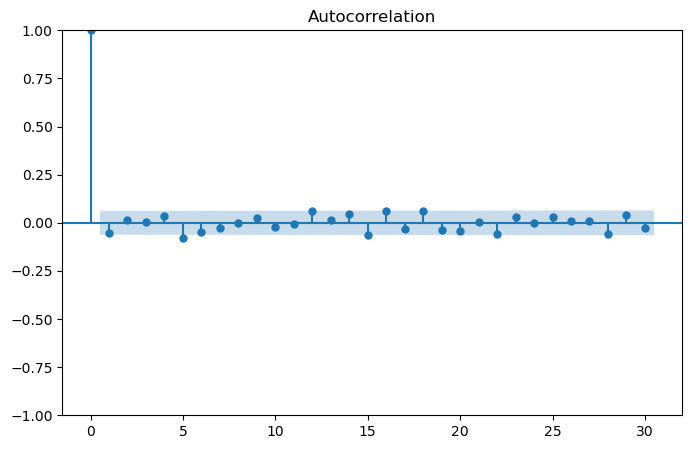

In [32]:
fig, ax = plt.subplots(figsize=(8, 5))
smt.graphics.plot_acf(df_diff['Adj Close'], ax=ax, lags=30)
plt.show()

From the plot above, the no of lags for MA seems to be 7

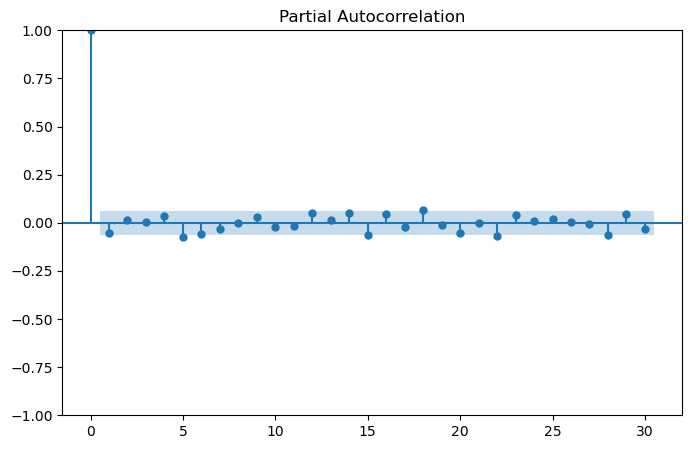

In [40]:
fig, ax = plt.subplots(figsize=(8, 5))
smt.graphics.plot_pacf(df_diff['Adj Close'], ax=ax, lags=30)
plt.show()

From the plot above, the no of lags for AR seems to be 7

In [42]:
#find the best order for ARIMA
best_aic = float('inf')  
best_order = None

for i in range(1, 7):
    for j in range(1, 7):
        model = ARIMA(df['Adj Close'], order=(i, 0, j))
        result = model.fit()
        current_aic = result.aic
        if current_aic < best_aic:
            best_aic = current_aic
            best_order = (i, j)

print(f"Best AIC: {best_aic}, Best Order: AR={best_order[0]}, MA={best_order[1]}")


Best AIC: 7714.719752290613, Best Order: AR=3, MA=2


In [43]:
#Modelling
model=ARIMA(df['Adj Close'],order=(3,1,2))
arima=model.fit()

In [44]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 1009
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -3845.494
Date:                Sat, 03 Jun 2023   AIC                           7702.988
Time:                        12:16:29   BIC                           7732.483
Sample:                             0   HQIC                          7714.194
                               - 1009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4760      0.066      7.162      0.000       0.346       0.606
ar.L2         -0.8800      0.059    -15.004      0.000      -0.995      -0.765
ar.L3         -0.0021      0.030     -0.071      0.943      -0.061       0.057
ma.L1         -0.5299      0.059     -9.002      0.000      -0.645      -0.414
ma.L2          0.9128      0.056     16.183      0.000       0.802       1.023
sigma2       120.7551      1.938     62.308      0.000     116.957     124.554
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              9754.66
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.24   Skew:                            -0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Prediction

<Axes: >

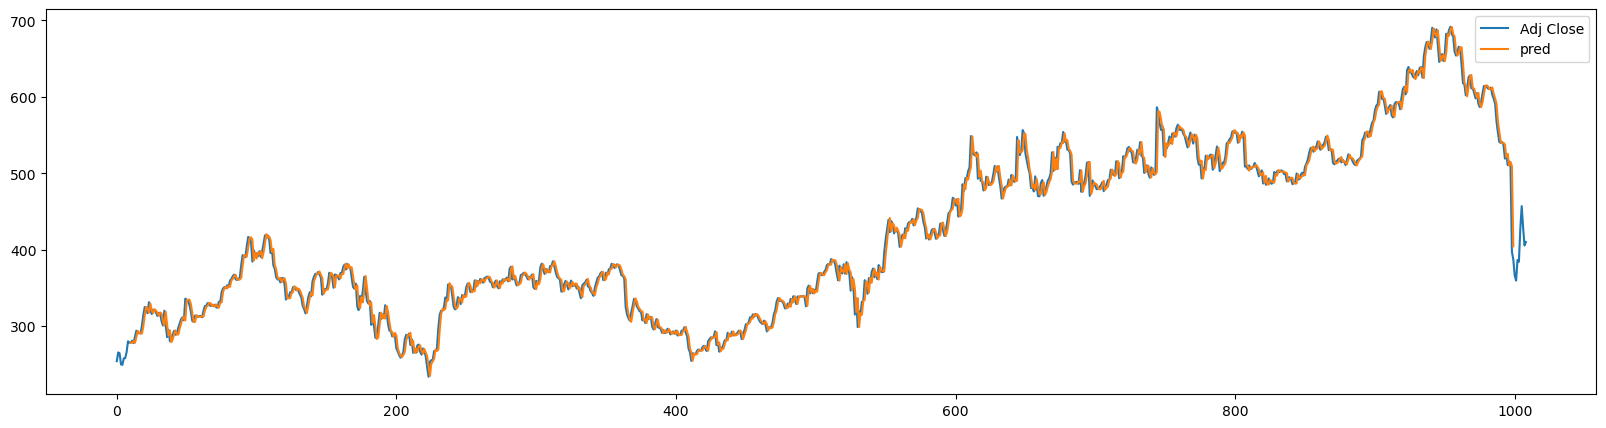

In [45]:
df['pred']=arima.predict(start=10,end=999)
df[["Adj Close","pred"]].plot(figsize=(20,5))

## Forecasting

In [57]:
fc= arima.forecast(30) 
print(fc)

1009    411.361387
1010    406.918115
1011    403.745094
1012    406.142302
1013    410.085018
1014    409.858908
1015    406.276623
1016    404.762106
1017    407.194087
1018    409.692051
1019    408.744136
1020    406.089582
1021    405.654904
1022    407.786009
1023    409.188538
1024    407.981686
1025    406.168497
1026    406.364488
1027    408.055936
1028    408.692423
1029    407.506501
1030    406.378321
1031    406.883575
1032    408.119380
1033    408.265382
1034    407.246302
1035    406.630129
1036    407.233312
1037    408.064813
1038    407.931107
Name: predicted_mean, dtype: float64


<Axes: >

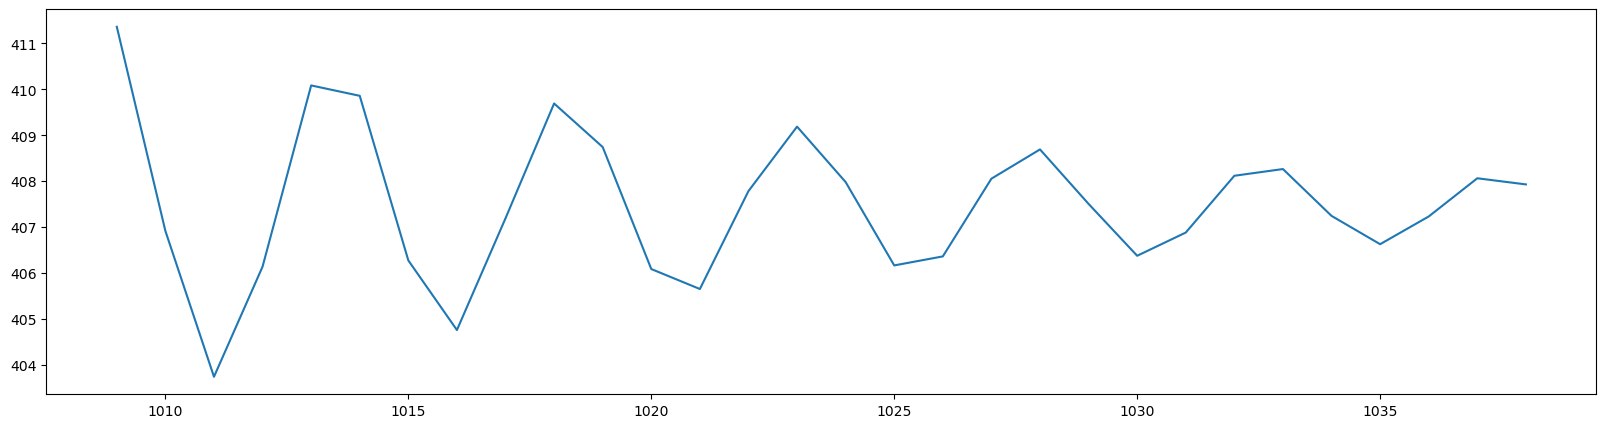

In [58]:
#plot the forecaseted values
fc.plot(figsize=(20,5))

plot forcasted values along with the time series data

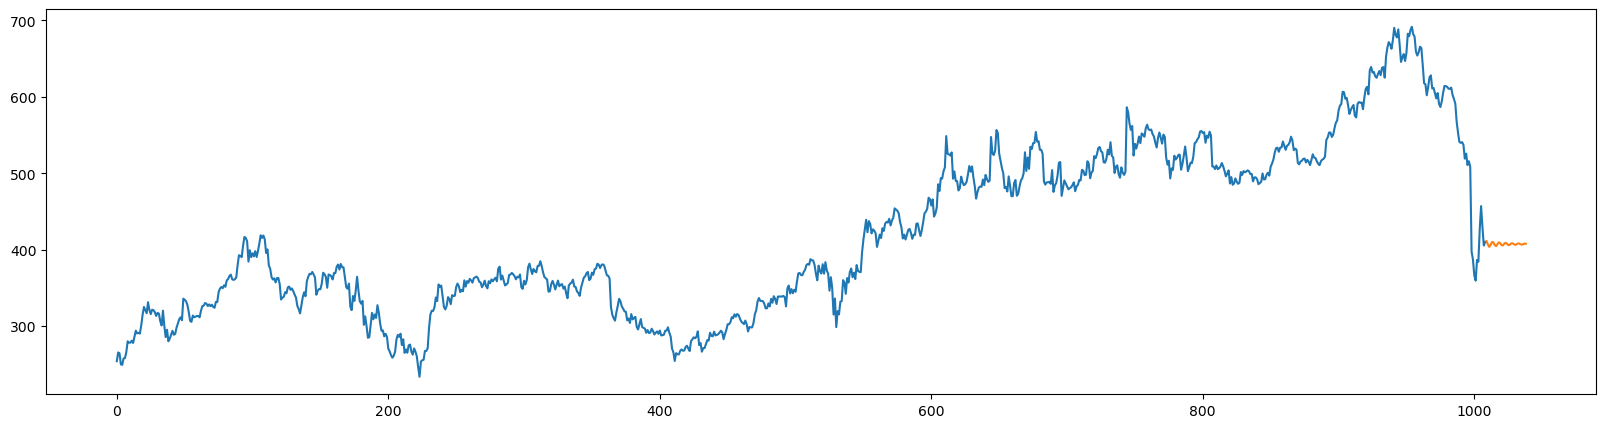

In [59]:
plt.figure(figsize=(20,5))
plt.plot(df["Adj Close"])
plt.plot(fc)

## Conclusion

An ARIMA model was developed to forecast Netflix stock prices for the next 30 days. The model was trained on historical "Adj Close" prices and optimized using the AIC criterion. The forecasted values were plotted on a graph. The ARIMA model efectively provides an estimate of future stock prices.